### Load libraries

In [1]:
import pathlib
import sys

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src.pretrain import linear_probe

### Load data

In [2]:
# Check if file exists:
if (GIT_ROOT / "data/clip-embeddings/cifar10_clip.npz").exists():
    d = np.load(GIT_ROOT / "data/clip-embeddings/cifar10_clip.npz")
else:
    d = np.load("/home/gridsan/groups/ccg/data/scaling/clip-embeddings/cifar10_clip.npz")

XS_TRAIN, YS_TRAIN = d["xs_train"], d["ys_train"]
XS_TEST, YS_TEST = d["xs_test"], d["ys_test"]
print(XS_TRAIN.shape, XS_TEST.shape)
DS = linear_probe.Dataset(XS_TRAIN, YS_TRAIN, XS_TEST, YS_TEST)

(50000, 768) (10000, 768)


### Collect scaling data

In [3]:
DATA = []

In [4]:
for n_train in tqdm(list(range(1, 16)) + [32, 64, 100, 500, 1000]):
    for C in [0.01, 1, 100]:
        for seed in range(10):
            for n_classes in [2, 5, 10]:
                DATA.append(
                    linear_probe.run_experiment(
                        ds=DS,
                        n_train=n_train,
                        n_classes=n_classes,
                        C=C,
                        max_iter=10000,
                        seed=seed,
                    )
                )

  0%|          | 0/20 [00:00<?, ?it/s]

/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: div

In [14]:
for n_train in tqdm([5000, 10000, 50000]):
    for C in [0.01, 1, 100]:
        for seed in range(1):
            for n_classes in [2, 5, 10]:
                with np.errstate(divide='ignore'):
                    DATA.append(
                        linear_probe.run_experiment(
                            ds=DS,
                            n_train=n_train,
                            n_classes=n_classes,
                            C=C,
                            max_iter=10000,
                            seed=seed,
                        )
                    )

  0%|          | 0/3 [00:00<?, ?it/s]

# Analyze data

In [15]:
df = pd.DataFrame(DATA)
# df = pd.read_csv("clip-cifar-scaling.csv")
df["err"] = 1 - df.acc

# Merge old data in
# old_df = pd.read_csv("clip-cifar-scaling.csv")
# df = pd.concat([old_df, df], ignore_index=True)
df

,n_classes,C,max_iter,seed,n_train,acc,xent,err
0,2,0.01,10000,0,1,0.5000,inf,0.5000
1,5,0.01,10000,0,1,0.2000,inf,0.8000
2,10,0.01,10000,0,1,0.1000,inf,0.9000
3,2,0.01,10000,1,1,0.5000,inf,0.5000
4,5,0.01,10000,1,1,0.2000,inf,0.8000
...,...,...,...,...,...,...,...,...
1822,5,1.00,10000,0,25000,0.9896,0.165949,0.0104
1823,10,1.00,10000,0,50000,0.9785,0.132802,0.0215
1824,2,100.00,10000,0,10000,0.9995,0.013041,0.0005
1825,5,100.00,10000,0,25000,0.9880,2.642376,0.0120


In [16]:
# df.to_csv("clip-cifar-scaling.csv", index=False)

### CLIP scaling

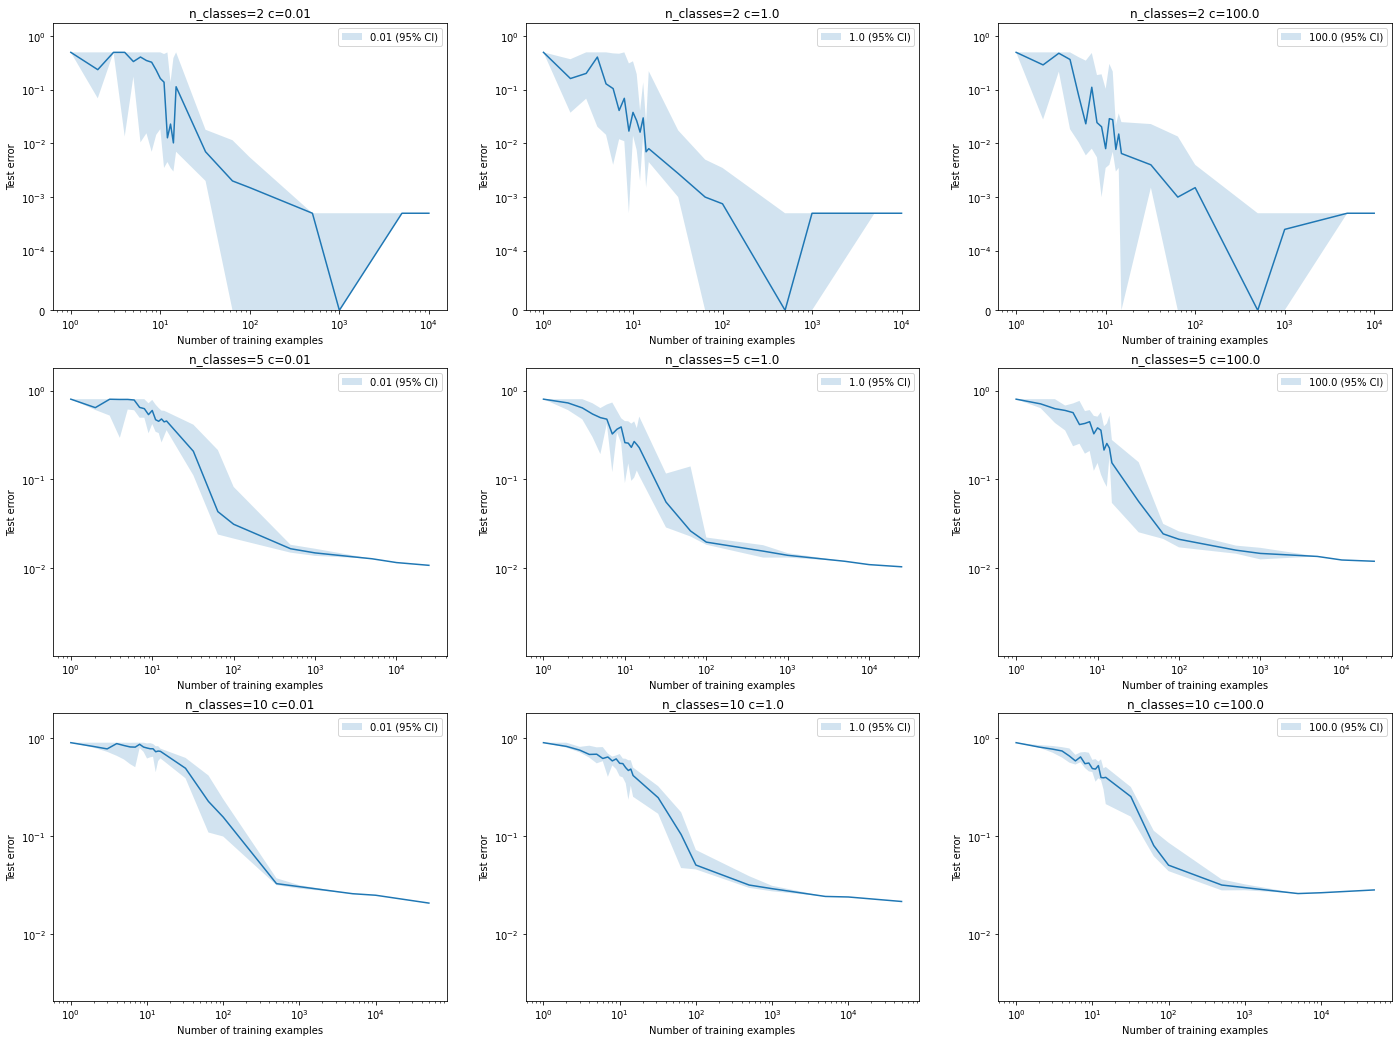

In [17]:
plt.figure(figsize=(24, 18))

plot_idx = 0
for i, n_classes in enumerate(df.n_classes.unique()):
    for c in sorted(df.C.unique()):
        plot_idx += 1
        plt.subplot(df.n_classes.nunique(), df.C.nunique(), plot_idx)

        gb = df.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).err
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(mid.index, mid)
        plt.fill_between(
            mid.index, lo, hi, alpha=0.2, label=f"{c} (95% CI)"
        )

        plt.ylim(0.1 * df.query(f"n_classes == {n_classes}").err.min(), 2 * df.err.max())

        plt.title(f"{n_classes=} {c=}")
        plt.legend()
        plt.xscale("log")
        plt.yscale("symlog", linthresh=1e-4)
        plt.xlabel("Number of training examples")
        plt.ylabel("Test error")

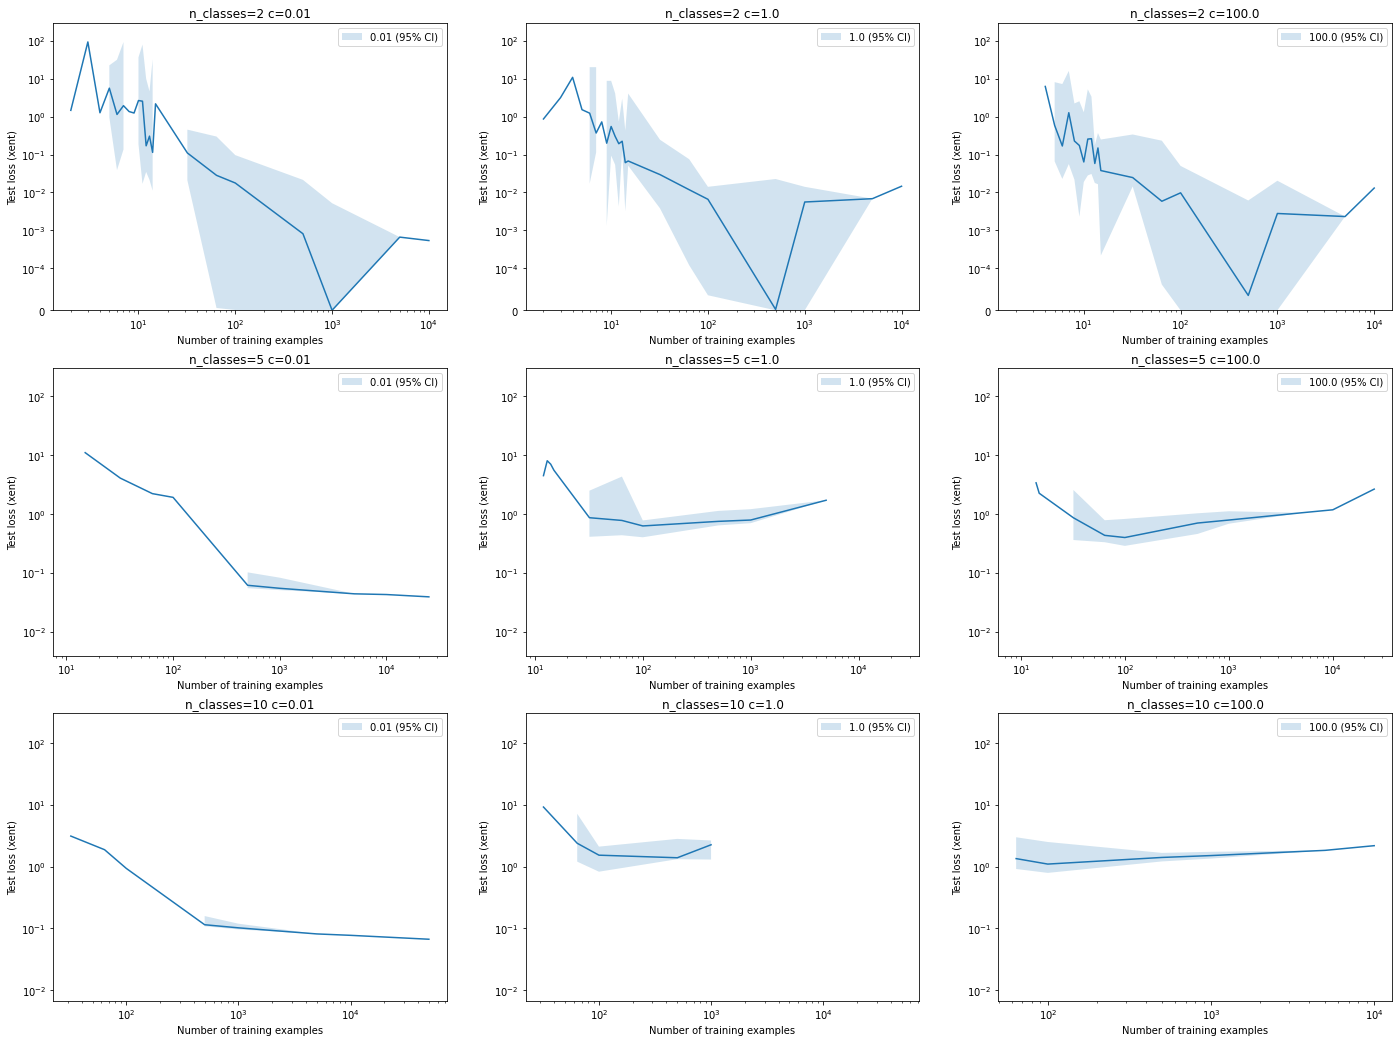

In [18]:
plt.figure(figsize=(24, 18))

plot_idx = 0
for i, n_classes in enumerate(df.n_classes.unique()):
    for c in sorted(df.C.unique()):
        plot_idx += 1
        plt.subplot(df.n_classes.nunique(), df.C.nunique(), plot_idx)

        gb = df.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).xent
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(mid.index, mid)
        plt.fill_between(
            mid.index, lo, hi, alpha=0.2, label=f"{c} (95% CI)"
        )

        with pd.option_context('mode.use_inf_as_na', True):
            plt.ylim(0.1 * df.query(f"n_classes == {n_classes}").xent.min(), 2 * df.dropna().xent.max())

        plt.title(f"{n_classes=} {c=}")
        plt.legend()
        plt.xscale("log")
        plt.yscale("symlog", linthresh=1e-4)
        plt.xlabel("Number of training examples")
        plt.ylabel("Test loss (xent)")

One thing to note about the above plots: The last three points are only single samples and do not have error bars!

### CLIP vs natural scaling

In [19]:
df_bahri = pd.read_csv(GIT_ROOT / "data/bahri-cifar10/wpd-clean.csv")
df_bahri.tail()

,n_train,err,xent
9,20000,0.061496,0.235242
10,30000,0.050142,0.192691
11,32768,0.046701,0.179879
12,40000,0.042607,0.164112
13,50000,0.036122,0.137861


In [20]:
df_prune_scratch = pd.read_csv(GIT_ROOT / "data/sorscher-cifar10/scratch/wpd-clean.csv")
df_prune_scratch["err"] = df_prune_scratch.errp / 100
df_prune_scratch.tail()

,n_train,errp,err
13,10204.034771,8.564766,0.085648
14,12200.279230,7.033175,0.070332
15,19825.925427,5.522567,0.055226
16,24835.575267,4.606628,0.046066
17,29809.793966,4.514735,0.045147


In [21]:
df_prune_transfer = pd.read_csv(GIT_ROOT / "data/sorscher-cifar10/transfer/wpd-clean.csv")
df_prune_transfer.tail()

,n_train,err
9,2384.730091,0.024559
10,3409.498972,0.019425
11,4992.200101,0.015317
12,6969.365290,0.014589
13,9964.248735,0.013234


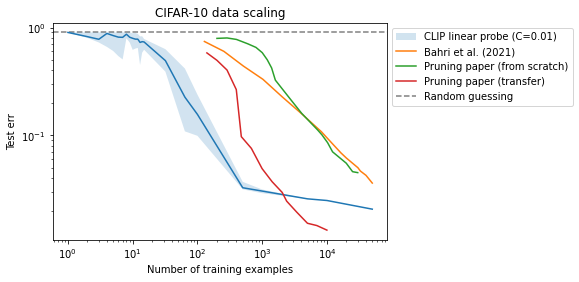

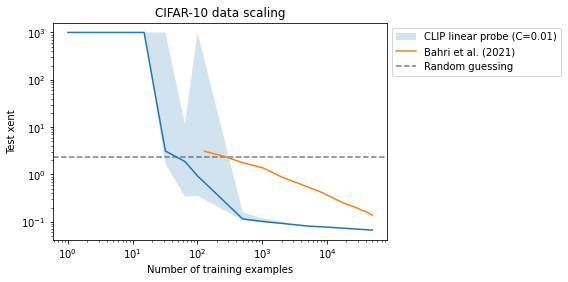

In [22]:
for metric in ["err", "xent"]:
    C = 0.01
    gb = (
        df.replace(np.infty, 1e3)
        .query(f"n_classes == 10 & C == {C}")
        .groupby("n_train")[metric]
    )
    lo = gb.min()
    mid = gb.median()
    hi = gb.max()

    plt.plot(mid.index, mid)
    plt.fill_between(
        mid.index, lo, hi, alpha=0.2, label=f"CLIP linear probe ({C=})"
    )

    plt.plot(df_bahri.n_train, df_bahri[metric], label="Bahri et al. (2021)")

    if metric == "err":
        plt.plot(df_prune_scratch.n_train, df_prune_scratch[metric], label="Pruning paper (from scratch)")
        plt.plot(df_prune_transfer.n_train, df_prune_transfer[metric], label="Pruning paper (transfer)")

    plt.axhline(
        0.9 if metric == "err" else -np.log(0.1),
        color="k",
        linestyle="--",
        label="Random guessing",
        zorder=-10,
        alpha=0.5,
    )

    plt.title(f"CIFAR-10 data scaling")
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Number of training examples")
    plt.ylabel(f"Test {metric}")

    # Plot legend on top right of figure
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()


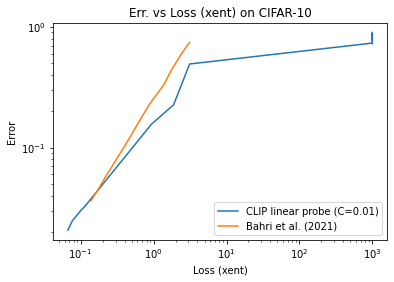

In [23]:
C = 0.01
gb = (
    df.replace(np.infty, 1e3)
    .query(f"n_classes == 10 & C == {C}")
    .groupby("n_train")
)
mid_err = gb.err.median()
mid_xent = gb.xent.median()

plt.plot(mid_xent, mid_err, label=f"CLIP linear probe ({C=})")
plt.plot(df_bahri.xent, df_bahri.err, label="Bahri et al. (2021)")

plt.title(f"Err. vs Loss (xent) on CIFAR-10")

plt.xscale("log")
plt.yscale("log")
plt.ylabel("Error")
plt.xlabel(f"Loss (xent)")
plt.legend();